# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and define constants

Import libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
from mpl_toolkits.mplot3d import Axes3D # Axes3D for 3D visualization
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import timeit                      # timing how long it takes to import libraries
from scipy.optimize import fsolve  # used for solving system of nonlin eqs. (particle intersections)
import warnings                    # used for particle intersections
warnings.filterwarnings("ignore", category=RuntimeWarning) # used for particle intersections
import time                        # timing how long it takes to import libraries
from numba import jit, njit, types, typeof  # optimization library
from numba.typed import Dict, List          # optimized data structures


t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
# threshold_1 = 55 # for 36a
# threshold_1 = 99 # for 500nm_epoxy_2
# threshold_2 = 70 # for 500nm_epoxy_15
# threshold_3 = 85 # for 500nm_epoxy_22
threshold_1 = 55 # for 36a
threshold_2 = 35 # for 36b
threshold_3 = 45 # for 36e
# threshold_1 = 55 # for 36h

# nm_per_pixel_1 = 1000 / 131 # In 500nm_epoxy_2.jpg there are 131 pixels per 1 micrometer
# nm_per_pixel_2 = 500 / 108 	# In 500nm_epoxy_15.jpg there are 108 pixels per 0.5 micrometer
# nm_per_pixel_3 = 500 / 127  # In 500nm_epoxy_22.jpg there are 127 pixels per 0.5 micrometer
nm_per_pixel_1 = 100 / 113 	# In TES-II-36a.tif there are 113 pixels per 100 nm
nm_per_pixel_2 = 100 / 113 	# In TES-II-36b.tif there are 113 pixels per 100 nm
nm_per_pixel_3 = 100 / 113 	# In TES-II-36e.tif there are 113 pixels per 100 nm

print(str(expected_radius), "nm is expected particle radius")

100 nm is expected particle radius


## 2. Setup

grayscale, gaussian blur, binary threshold, noise removel, dilation, distance transform

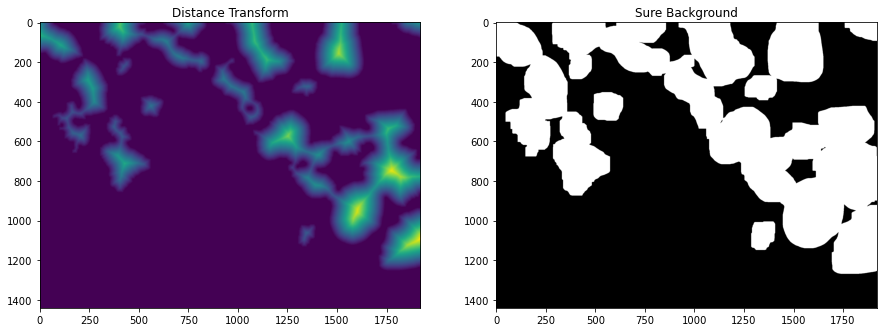

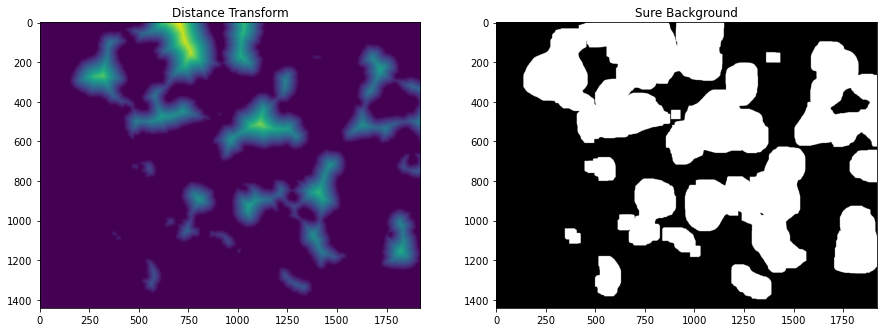

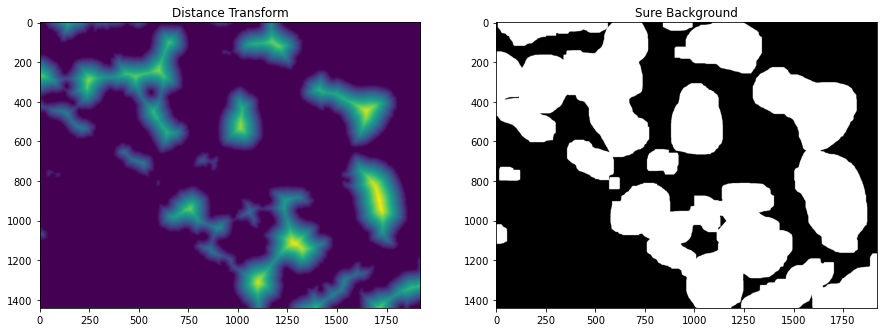

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME_1 = "./inputs/TES-36a-cropped.tif"
IMAGE_NAME_2 = "./inputs/TES-36b-cropped.tif"
IMAGE_NAME_3 = "./inputs/TES-36e-cropped.tif"
# IMAGE_NAME_1 = "./inputs/TES-36h-cropped.tif"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_2.jpg"
# IMAGE_NAME_2 = "./inputs/500nm_epoxy/500nm_epoxy_15.jpg"
# IMAGE_NAME_3 = "./inputs/500nm_epoxy/500nm_epoxy_22.jpg"

color_image_1, dist_transform_1, sure_bg_1 = setup(IMAGE_NAME_1, threshold_1, False)
color_image_2, dist_transform_2, sure_bg_2 = setup(IMAGE_NAME_2, threshold_2, False)
color_image_3, dist_transform_3, sure_bg_3 = setup(IMAGE_NAME_3, threshold_3, False)

## 3. Perform watershed and find contours

Find the threshold value that will break up agglomerates into individual particles

In [4]:
dist_transform_thresh_1 = get_watershed_threshold(dist_transform_1, sure_bg_1, color_image_1, expected_radius, nm_per_pixel_1)
dist_transform_thresh_2 = get_watershed_threshold(dist_transform_2, sure_bg_2, color_image_2, expected_radius, nm_per_pixel_2)
dist_transform_thresh_3 = get_watershed_threshold(dist_transform_3, sure_bg_3, color_image_3, expected_radius, nm_per_pixel_3)


Get watershed markers

In [5]:
# watershed markers for finding particles (no agglomerates)
watershed_markers_1 = get_watershed_markers(dist_transform_1, dist_transform_thresh_1, sure_bg_1, color_image_1, False)
watershed_markers_2 = get_watershed_markers(dist_transform_2, dist_transform_thresh_2, sure_bg_2, color_image_2, False)
watershed_markers_3 = get_watershed_markers(dist_transform_3, dist_transform_thresh_3, sure_bg_3, color_image_3, False)

# watershed markers for finding agglomerates
agg_watershed_markers_1 = get_watershed_markers(dist_transform_1, 0.1, sure_bg_1, color_image_1, False)
agg_watershed_markers_2 = get_watershed_markers(dist_transform_2, 0.1, sure_bg_2, color_image_2, False)
agg_watershed_markers_3 = get_watershed_markers(dist_transform_3, 0.1, sure_bg_3, color_image_3, False)

Get contours

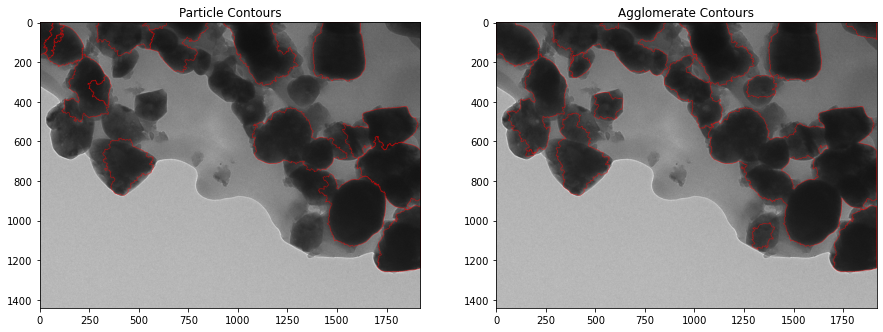

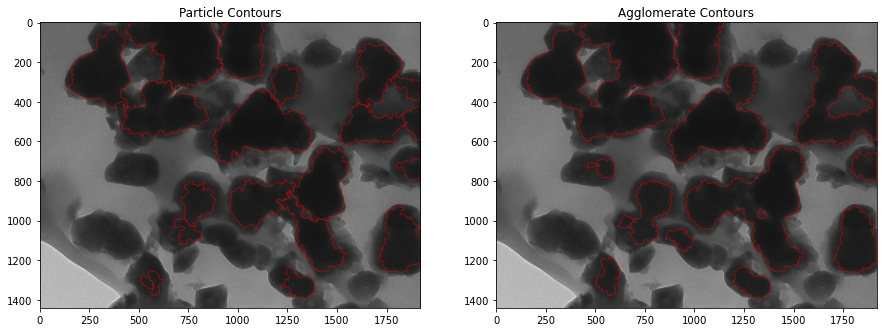

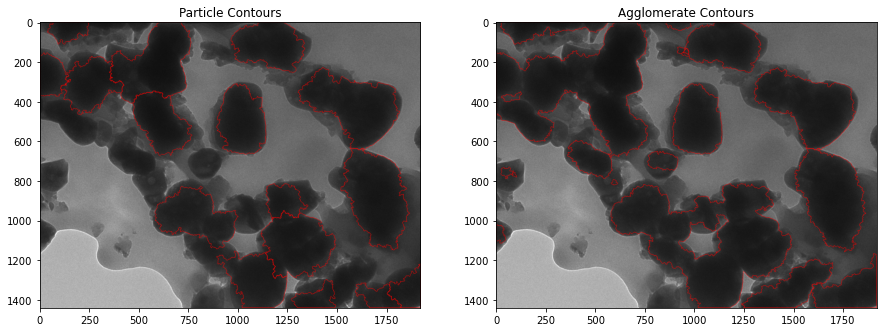

In [6]:
contour_colors_1, chords_color_copy_1 = get_contour_colors(watershed_markers_1, color_image_1)
contour_colors_2, chords_color_copy_2 = get_contour_colors(watershed_markers_2, color_image_2)
contour_colors_3, chords_color_copy_3 = get_contour_colors(watershed_markers_3, color_image_3)

agg_contour_colors_1, agg_chords_color_copy_1 = get_contour_colors(agg_watershed_markers_1, color_image_1)
agg_contour_colors_2, agg_chords_color_copy_2 = get_contour_colors(agg_watershed_markers_2, color_image_2)
agg_contour_colors_3, agg_chords_color_copy_3 = get_contour_colors(agg_watershed_markers_3, color_image_3)

display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_2, agg_chords_color_copy_2], ["Particle Contours", "Agglomerate Contours"], [1, 1])
display_images([chords_color_copy_3, agg_chords_color_copy_3], ["Particle Contours", "Agglomerate Contours"], [1, 1])

## 4. Finding centerpoints, getting areas, and replacing agglomerates with particles

Finding centerpoints

In [7]:
particles_1 = find_centerpoints(contour_colors_1, nm_per_pixel_1)
particles_2 = find_centerpoints(contour_colors_2, nm_per_pixel_2)
particles_3 = find_centerpoints(contour_colors_3, nm_per_pixel_3)

agg_particles_1 = find_centerpoints(agg_contour_colors_1, nm_per_pixel_1)
agg_particles_2 = find_centerpoints(agg_contour_colors_2, nm_per_pixel_2)
agg_particles_3 = find_centerpoints(agg_contour_colors_3, nm_per_pixel_3)

Getting areas

In [8]:
particle_areas_1 = get_areas(watershed_markers_1, nm_per_pixel_1)
particle_areas_2 = get_areas(watershed_markers_2, nm_per_pixel_2)
particle_areas_3 = get_areas(watershed_markers_3, nm_per_pixel_3)

agg_areas_1 = get_areas(agg_watershed_markers_1, nm_per_pixel_1)
agg_areas_2 = get_areas(agg_watershed_markers_2, nm_per_pixel_2)
agg_areas_3 = get_areas(agg_watershed_markers_3, nm_per_pixel_3)

In [9]:
# print(agg_areas_1)

Replacing agglomerates with particles

In [10]:
# TODO: standardize way of referring to unique particle ID, here particle == color

merge_particles_1, merge_contour_colors_1 = match_images(particles_1, contour_colors_1, agg_particles_1, agg_contour_colors_1, agg_areas_1, nm_per_pixel_1)
merge_particles_2, merge_contour_colors_2 = match_images(particles_2, contour_colors_2, agg_particles_2, agg_contour_colors_2, agg_areas_2, nm_per_pixel_2)
merge_particles_3, merge_contour_colors_3 = match_images(particles_3, contour_colors_3, agg_particles_3, agg_contour_colors_3, agg_areas_3, nm_per_pixel_3)
# [print(x, merge_particles[x]) for x in merge_particles.keys()]

## 5. Get long and short chord lengths

Get long chord lengths

In [11]:
long_pairs_1, merge_particles_1, merge_contour_colors_1 = get_long_chord_lengths(merge_particles_1, particles_1, contour_colors_1, merge_contour_colors_1, nm_per_pixel_1)
long_pairs_2, merge_particles_2, merge_contour_colors_2 = get_long_chord_lengths(merge_particles_2, particles_2, contour_colors_2, merge_contour_colors_2, nm_per_pixel_2)
long_pairs_3, merge_particles_3, merge_contour_colors_3 = get_long_chord_lengths(merge_particles_3, particles_3, contour_colors_3, merge_contour_colors_3, nm_per_pixel_3)


In [12]:
# print(long_pairs_1)
# print(merge_contour_colors_1)

Get short chord lengths

In [13]:
short_pairs_1, merge_particles_1 = get_short_chord_lengths(merge_particles_1, merge_contour_colors_1, long_pairs_1, nm_per_pixel_1)
short_pairs_2, merge_particles_2 = get_short_chord_lengths(merge_particles_2, merge_contour_colors_2, long_pairs_2, nm_per_pixel_2)
short_pairs_3, merge_particles_3 = get_short_chord_lengths(merge_particles_3, merge_contour_colors_3, long_pairs_3, nm_per_pixel_3)

In [14]:
# print(short_pairs_1)
# print(merge_particles_1)

In [15]:
merge_particles_1 = break_up_agglomerates(merge_particles_1, merge_contour_colors_1, nm_per_pixel_1, long_pairs_1, short_pairs_1)
merge_particles_2 = break_up_agglomerates(merge_particles_2, merge_contour_colors_2, nm_per_pixel_2, long_pairs_2, short_pairs_2)
merge_particles_3 = break_up_agglomerates(merge_particles_3, merge_contour_colors_3, nm_per_pixel_3, long_pairs_3, short_pairs_3)

Display chord lengths

In [16]:
# draw_long_lengths(chords_color_copy, long_pairs)
# draw_short_lengths(chords_color_copy, short_pairs)
# display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])
# plt.savefig("chords_color_copy_long_short_chord_lengths.png", dpi=500)

draw_long_lengths(chords_color_copy_1, long_pairs_1)
draw_long_lengths(chords_color_copy_2, long_pairs_2)
draw_long_lengths(chords_color_copy_3, long_pairs_3)

draw_long_lengths(agg_chords_color_copy_1, long_pairs_1)
draw_long_lengths(agg_chords_color_copy_2, long_pairs_2)
draw_long_lengths(agg_chords_color_copy_3, long_pairs_3)

draw_short_lengths(chords_color_copy_1, short_pairs_1)
draw_short_lengths(chords_color_copy_2, short_pairs_2)
draw_short_lengths(chords_color_copy_3, short_pairs_3)

draw_short_lengths(agg_chords_color_copy_1, short_pairs_1)
draw_short_lengths(agg_chords_color_copy_2, short_pairs_2)
draw_short_lengths(agg_chords_color_copy_3, short_pairs_3)

# display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Long & Short Chord Lengths", "Long & Short Chord Lengths Agg"], [0, 0])
# plt.savefig("500nm_epoxy_15_chord_lengths.png", dpi=500)

# draw_long_lengths(agg_chords_color_copy, long_pairs)
# draw_short_lengths(agg_chords_color_copy, short_pairs)
# display_images([agg_chords_color_copy], ["Agg Long & Short Chord Lengths"], [0])
# plt.savefig("./visualizations/36b_troubleshooting.png", dpi=500)

In [17]:
# display_images([chords_color_copy_1], ["Long & Short Chord Lengths Layer 2"], [0])
# display_images([chords_color_copy_2], ["Long & Short Chord Lengths Layer 15"], [0])
# display_images([chords_color_copy_3], ["Long & Short Chord Lengths Layer 22"], [0])

# display_images([agg_chords_color_copy_3], ["Long & Short Chord Lengths Layer e"], [0])

# plt.savefig("long_short_chord_lengths_e.png", dpi=500)

## 6. Get c radii and layer information

In [18]:
merge_particles_1 = get_c(merge_particles_1)
merge_particles_2 = get_c(merge_particles_2)
merge_particles_3 = get_c(merge_particles_3)

# merge_particles_1 = set_max_c(merge_particles_1)
# merge_particles_2 = set_max_c(merge_particles_2)
# merge_particles_3 = set_max_c(merge_particles_3)


In [19]:
# print(merge_particles_1)
# print(merge_particles_2)
# print(merge_particles_3)

In [20]:
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)

In [21]:
# adding particles to layer b to get to 20% volume loading
# merge_particles_2[30] = [('x', 350), ('y', 900), ('a', 150), ('theta', 0), ('b', 99), ('c', 100)]
# merge_particles_2[31] = [('x', 1250), ('y', 100), ('a', 150), ('theta', 0), ('b', 100), ('c', 100)]
# merge_particles_2[32] = [('x', 750), ('y', 1100), ('a', 130), ('theta', 0), ('b', 75), ('c', 100)]
# merge_particles_2[33] = [('x', 275), ('y', 600), ('a', 150), ('theta', 90), ('b', 80), ('c', 100)]
# merge_particles_2[34] = [('x', 275), ('y', 1100), ('a', 100), ('theta', 0), ('b', 90), ('c', 100)]
# merge_particles_2[35] = [('x', 1000), ('y', 1000), ('a', 100), ('theta', 0), ('b', 90), ('c', 100)]
# merge_particles_2[36] = [('x', 1275), ('y', 350), ('a', 120), ('theta', 90), ('b', 80), ('c', 100)]
# merge_particles_2[37] = [('x', 1475), ('y', 725), ('a', 120), ('theta', 90), ('b', 80), ('c', 100)]
# merge_particles_2[38] = [('x', 625), ('y', 620), ('a', 100), ('theta', 90), ('b', 60), ('c', 100)]
# merge_particles_2[39] = [('x', 1400), ('y', 1100), ('a', 100), ('theta', 90), ('b', 70), ('c', 100)]

In [22]:
# merge_particles_1 = layer_xy_rotate_particles(merge_particles_1)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)
merge_particles_1 = layer_scale_particles(merge_particles_1)
merge_particles_2 = layer_scale_particles(merge_particles_2)
merge_particles_3 = layer_scale_particles(merge_particles_3)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)

delete duplicate particles in merge_particles dictionaries

In [23]:
num_before = len(merge_particles_1) + len(merge_particles_2) + len(merge_particles_3)
merge_particles_1 = delete_duplicates(merge_particles_1)
merge_particles_2 = delete_duplicates(merge_particles_2)
merge_particles_3 = delete_duplicates(merge_particles_3)
num_after = len(merge_particles_1) + len(merge_particles_2) + len(merge_particles_3)
print(num_before-num_after, "particles deleted")

4 particles deleted


In [24]:
info_1 = get_layer_info(merge_particles_1)
info_2 = get_layer_info(merge_particles_2)
info_3 = get_layer_info(merge_particles_3)

In [25]:
# print(info_1)
# print(info_2)
# print(info_3)

## 7. Render layer

<IPython.core.display.Javascript object>


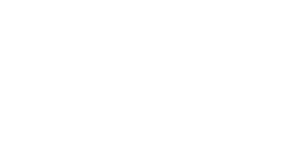

<IPython.core.display.Javascript object>


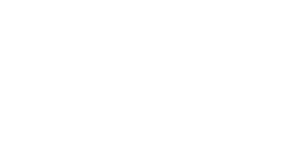

<IPython.core.display.Javascript object>


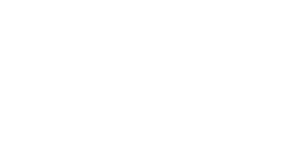

<IPython.core.display.Javascript object>


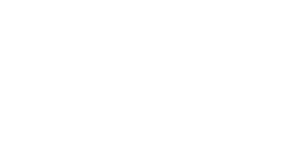

<IPython.core.display.Javascript object>


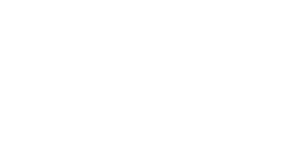

<IPython.core.display.Javascript object>


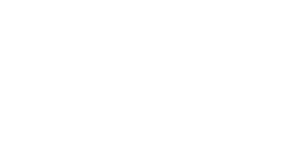

In [26]:
%matplotlib notebook

layer_render(merge_particles_1, info_1)

## 8. Combine layers

In [27]:
composite_particles_123, composite_info_123 = combine_layers([merge_particles_1,merge_particles_2,merge_particles_3], [info_1, info_2, info_3])
# composite_particles_132, composite_info_132 = combine_layers([merge_particles_1,merge_particles_3,merge_particles_2], [info_1, info_3, info_2])
# composite_particles_213, composite_info_213 = combine_layers([merge_particles_2,merge_particles_1,merge_particles_3], [info_2, info_1, info_3])
# composite_particles_231, composite_info_231 = combine_layers([merge_particles_2,merge_particles_3,merge_particles_1], [info_2, info_3, info_1])
# composite_particles_312, composite_info_312 = combine_layers([merge_particles_3,merge_particles_1,merge_particles_2], [info_3, info_1, info_2])
# composite_particles_321, composite_info_321 = combine_layers([merge_particles_3,merge_particles_2,merge_particles_1], [info_3, info_2, info_1])

In [28]:
# composite_particles_23, composite_info_23 = combine_layers([merge_particles_2,merge_particles_3], [info_2, info_3])

# composite_particles_232, composite_info_232 = combine_layers([merge_particles_2,merge_particles_3,merge_particles_2], [info_2, info_3, info_2])


In [29]:
# composite_particles_1, composite_info_1 = combine_layers([merge_particles_1], [info_1])
# composite_particles_2, composite_info_2 = combine_layers([merge_particles_2], [info_2])
# composite_particles_3, composite_info_3 = combine_layers([merge_particles_3], [info_3])

In [30]:
# composite_particles_111, composite_info_111 = combine_layers([merge_particles_1,merge_particles_1,merge_particles_1], [info_1, info_1, info_1])


In [31]:
def decrease_vol_loading(composite_particles, composite_info, desired_vol_loading):
    vol_loading = composite_info[6]
    total_particles_vol = composite_info[0]
    vol_prism = composite_info[1] * composite_info[2] * composite_info[3]
    particles_deleted = []
    max_ID = np.max(list(composite_particles.keys()))
    while vol_loading > desired_vol_loading and (vol_loading-desired_vol_loading) >= 0.005:
        random_id = rand_int = np.random.randint(1, max_ID)
        while random_id in particles_deleted:
            random_id = rand_int = np.random.randint(1, max_ID)
        particle_data = composite_particles[random_id]
        a = particle_data[2][1]
        b = particle_data[4][1]
        c = particle_data[5][1]
        total_particles_vol -= (4/3)*np.pi*a*b*c
        vol_loading = total_particles_vol/vol_prism
        particles_deleted += [random_id]
        
    new_particles = {}
    for particle in composite_particles:
        if particle not in particles_deleted:
            particle_data = composite_particles[particle]
            new_particles[particle] = [particle_data[0], particle_data[1], particle_data[2], particle_data[3], particle_data[4], particle_data[5], particle_data[6]]
    
    new_info = [total_particles_vol, composite_info[1], composite_info[2], composite_info[3], composite_info[4], composite_info[5], vol_loading]
    
    return new_particles, new_info


In [32]:
composite_particles_123_1, composite_info_123_1 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
composite_particles_123_2, composite_info_123_2 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
composite_particles_123_3, composite_info_123_3 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
composite_particles_123_4, composite_info_123_4 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
composite_particles_123_5, composite_info_123_5 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
composite_particles_123_6, composite_info_123_6 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)
composite_particles_123_7, composite_info_123_7 = decrease_vol_loading(composite_particles_123, composite_info_123, 0.1)

## 9. Get Metrics

In [33]:
# get_electrode_particle_metric(composite_particles_123, composite_info_123)
# get_electrode_particle_metric(composite_particles_132, composite_info_132)
# get_electrode_particle_metric(composite_particles_213, composite_info_213)
# get_electrode_particle_metric(composite_particles_231, composite_info_231)
# get_electrode_particle_metric(composite_particles_312, composite_info_312)
# get_electrode_particle_metric(composite_particles_321, composite_info_321)

# get_electrode_particle_metric(composite_particles_1, composite_info_1)
# get_electrode_particle_metric(composite_particles_2, composite_info_2)
# get_electrode_particle_metric(composite_particles_3, composite_info_3)


In [34]:
get_electrode_particle_metric(composite_particles_123_1, composite_info_123_1)
get_electrode_particle_metric(composite_particles_123_2, composite_info_123_2)
get_electrode_particle_metric(composite_particles_123_3, composite_info_123_3)
get_electrode_particle_metric(composite_particles_123_4, composite_info_123_4)
get_electrode_particle_metric(composite_particles_123_5, composite_info_123_5)
get_electrode_particle_metric(composite_particles_123_6, composite_info_123_6)
get_electrode_particle_metric(composite_particles_123_7, composite_info_123_7)

In [35]:
# get_electrode_particle_metric(composite_particles_232, composite_info_232)

In [36]:
# get_electrode_particle_metric(composite_particles_111, composite_info_111)

In [37]:
# TODO: fix this

# get_volume_loading_metrics(composite_info_123, 2000)
# get_volume_loading_metrics(composite_info_132, 2000)
# get_volume_loading_metrics(composite_info_213, 2000)
# get_volume_loading_metrics(composite_info_231, 2000)
# get_volume_loading_metrics(composite_info_312, 2000)
# get_volume_loading_metrics(composite_info_321, 2000)

# get_volume_loading_metrics(composite_info_1, 2000)
# get_volume_loading_metrics(composite_info_2, 2000)
# get_volume_loading_metrics(composite_info_3, 2000)

## 10. Render Composite

<IPython.core.display.Javascript object>


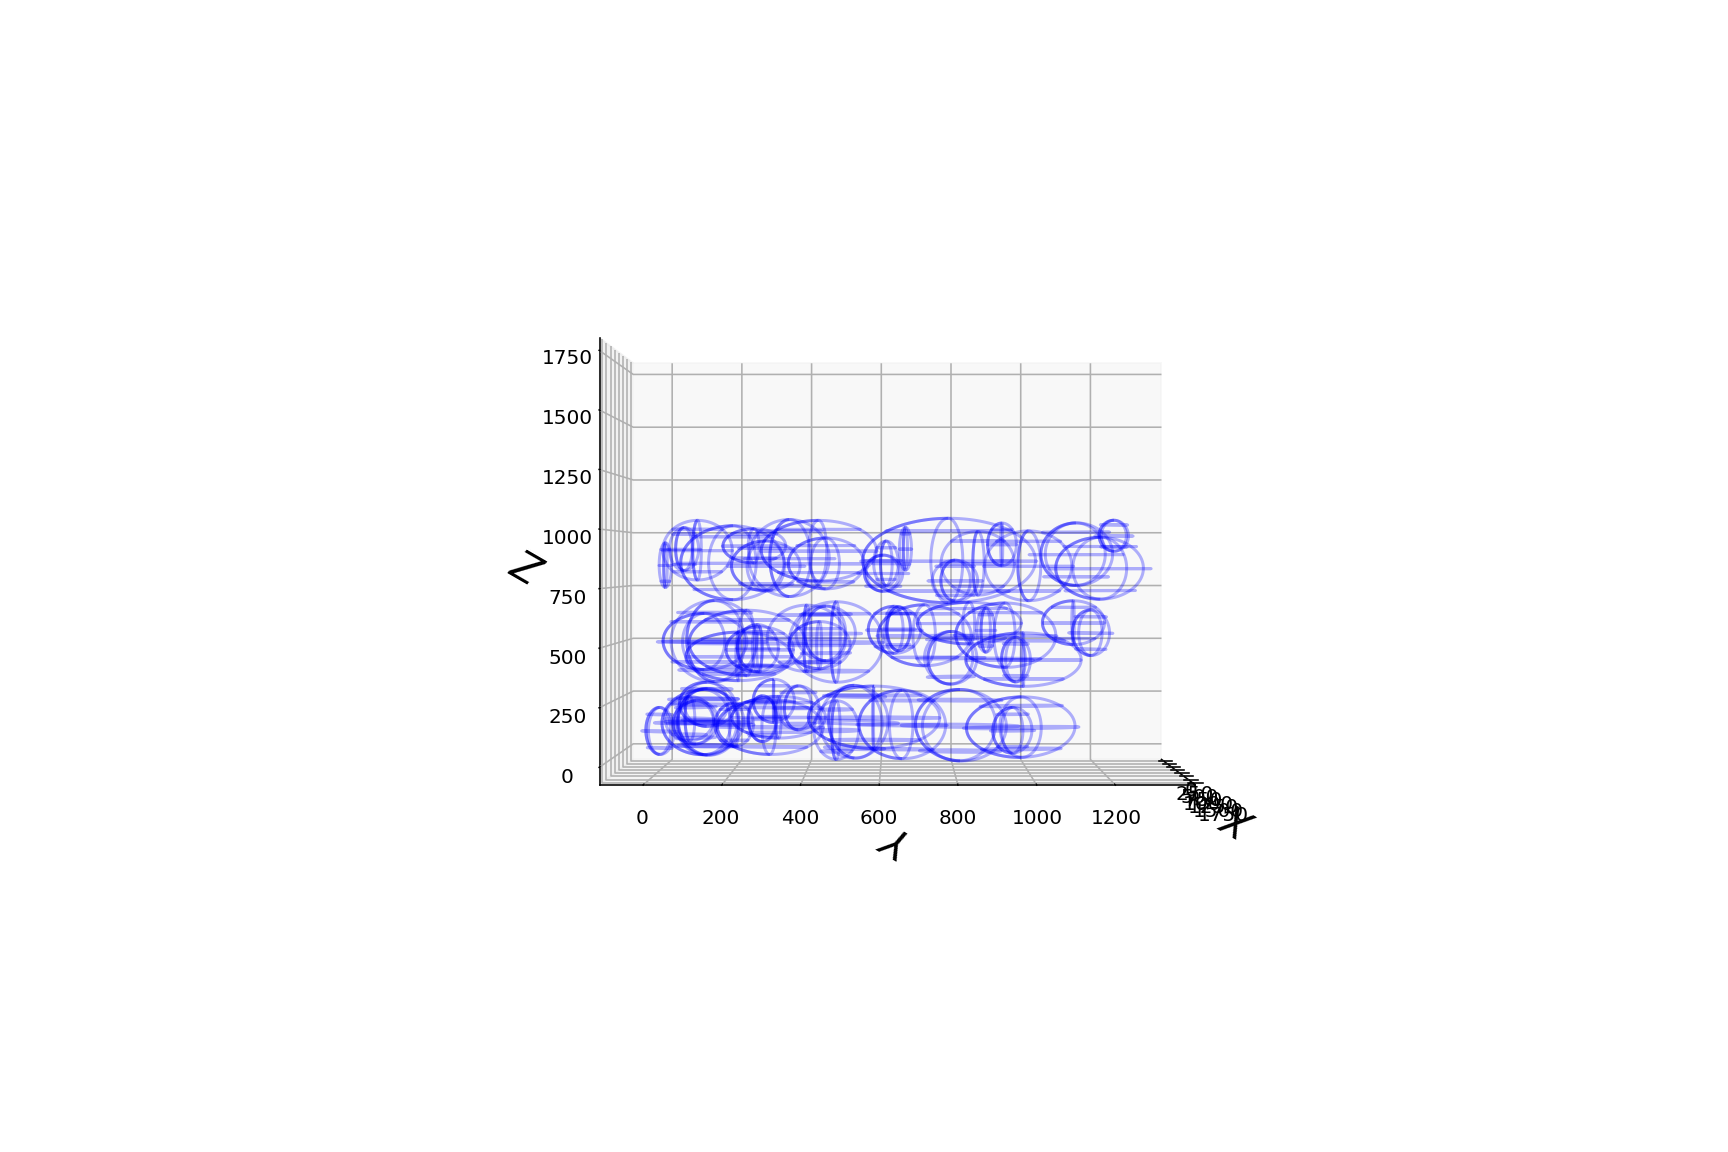

<IPython.core.display.Javascript object>


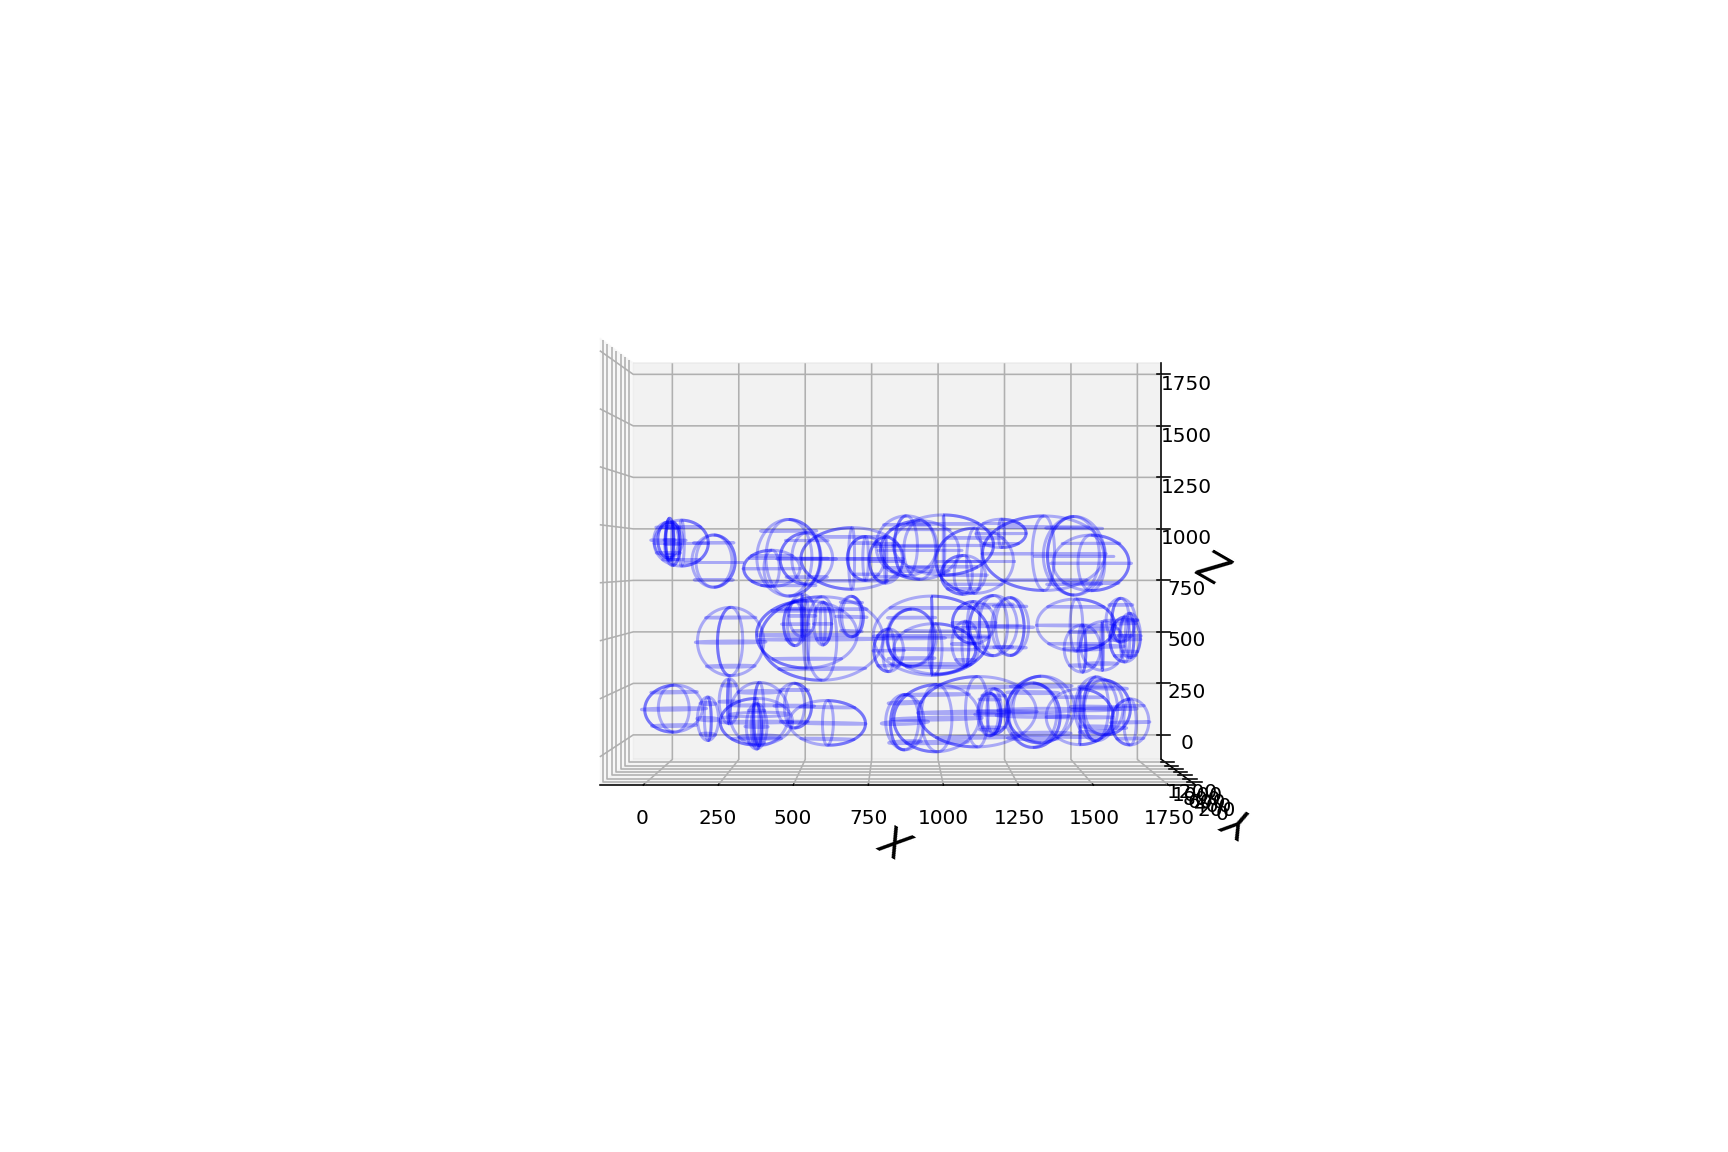

<IPython.core.display.Javascript object>


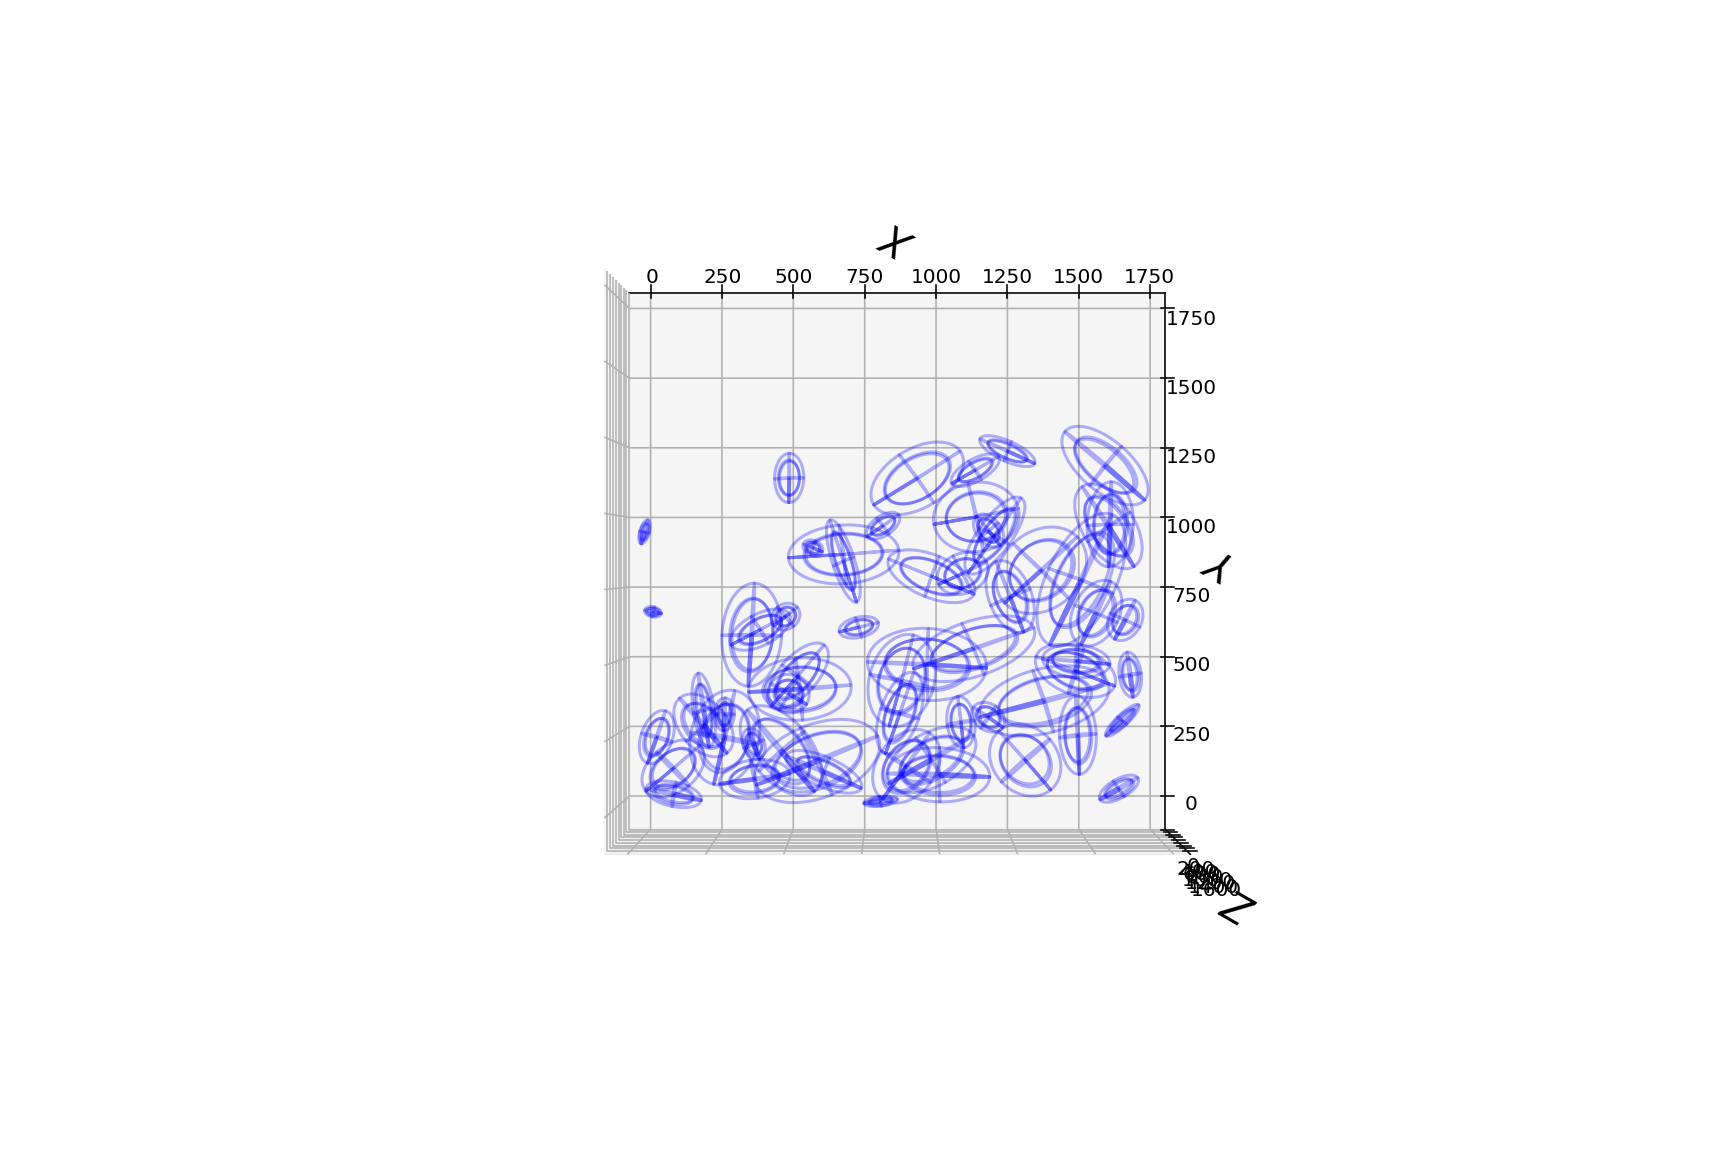

In [38]:
%matplotlib notebook

composite_render(composite_particles_123, composite_info_123)

## 11. Save to a text file

In [39]:
# generate_text_file(composite_particles_123, composite_info_123, "./outputs/11_04_21_500nm_2_15_22.txt")
# generate_text_file(composite_particles_132, composite_info_132, "./outputs/11_04_21_500nm_2_22_15.txt")
# generate_text_file(composite_particles_213, composite_info_213, "./outputs/11_04_21_500nm_15_2_22.txt")
# generate_text_file(composite_particles_231, composite_info_231, "./outputs/11_04_21_500nm_15_22_2.txt")
# generate_text_file(composite_particles_312, composite_info_312, "./outputs/11_04_21_500nm_22_2_15.txt")
# generate_text_file(composite_particles_321, composite_info_321, "./outputs/11_04_21_500nm_22_15_22.txt")

In [40]:
# generate_text_file(composite_particles_123_1, composite_info_123_1, "./outputs/14_04_21_abe_10_vol_loading_1.txt")
# generate_text_file(composite_particles_123_2, composite_info_123_2, "./outputs/14_04_21_abe_10_vol_loading_2.txt")
# generate_text_file(composite_particles_123_3, composite_info_123_3, "./outputs/14_04_21_abe_10_vol_loading_3.txt")
# generate_text_file(composite_particles_123_4, composite_info_123_4, "./outputs/14_04_21_abe_10_vol_loading_4.txt")
# generate_text_file(composite_particles_123_5, composite_info_123_5, "./outputs/14_04_21_abe_10_vol_loading_5.txt")
# generate_text_file(composite_particles_123_6, composite_info_123_6, "./outputs/14_04_21_abe_10_vol_loading_6.txt")
# generate_text_file(composite_particles_123_7, composite_info_123_7, "./outputs/14_04_21_abe_10_vol_loading_7.txt")

In [41]:
# generate_text_file(composite_particles_23, composite_info_23, "two_layer_be.txt")

# generate_text_file(composite_particles_111, composite_info_111, "./outputs/11_04_21_500nm_2_2_2.txt")

# generate_text_file(composite_particles_232, composite_info_232, "./outputs/11_04_21_500nm_15_22_15.txt")

In [42]:
# generate_text_file(composite_particles_1, composite_info_1, "./outputs/11_04_21_500nm_2.txt")
# generate_text_file(composite_particles_2, composite_info_2, "./outputs/11_04_21_500nm_15.txt")
# generate_text_file(composite_particles_3, composite_info_3, "./outputs/11_04_21_500nm_22.txt")

In [43]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 69.48727838898776 seconds
